<a href="https://colab.research.google.com/github/GaoangLiu/AA_ipynb/blob/master/Bag_of_Words_Meets_Bags_of_Popcorn_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!curl -o train.tsv ali.140714.xyz:8000/popcorn.tsv
!curl -o test.tsv ali.140714.xyz:8000/popcorn_test.tsv
!curl -o sample.csv ali.140714.xyz:8000/popcorn_sample.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32.0M  100 32.0M    0     0  3614k      0  0:00:09  0:00:09 --:--:-- 4197k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31.2M  100 31.2M    0     0  3782k      0  0:00:08  0:00:08 --:--:-- 4612k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   469  100   469    0     0    907      0 --:--:-- --:--:-- --:--:--   907


In [0]:
import os 
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
import tensorflow_hub as hub
import sklearn.metrics 
import sklearn.model_selection
from absl import logging
logging.set_verbosity(logging.INFO)
!pip install sentencepiece


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


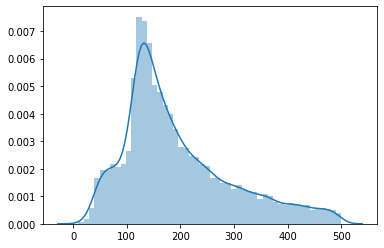

In [0]:
train = pd.read_csv('train.tsv', sep='\t')
words = train.review.str.split(' ').str.len()
sb.distplot([w for w in words if w <= 500])
# train.review.str.split(' ').str.len().hist()

In [0]:
import os 
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
import tensorflow_hub as hub
import sklearn.metrics 
import sklearn.model_selection
from absl import logging
logging.set_verbosity(logging.INFO)


# in case there is no such file in local path
if not os.path.exists('tokenization.py'):
    os.system('wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py')
import tokenization

def load_data():
    train = pd.read_csv('train.tsv', sep='\t')
    test = pd.read_csv('test.tsv', sep='\t')
    train['text'] = train.review
    train['target'] = train.sentiment
    test['text'] = test.review
    return train, test
  

def get_bert_layer():
    module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
    module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
    return hub.KerasLayer(module_url, trainable=True)
    

def get_tokenizer(bert_layer):
    vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
    do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
    return tokenization.FullTokenizer(vocab_file, do_lower_case)


def bert_encode(texts, tokenizer, max_len=512):
    # encode texts 
    tokens, masks, segments = [], [], []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len - 2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        cur_tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        cur_tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        tokens.append(cur_tokens)
        masks.append(pad_masks)
        segments.append(segment_ids)
    
    return np.array(tokens), np.array(masks), np.array(segments)


def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

    return model 


In [0]:
train, test = load_data()
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(train.text.values, train.target, test_size=0.2, random_state=0)
logging.info("Data loaded and split")


INFO:absl:Data loaded and split


In [0]:
max_len = 120
bert_layer = get_bert_layer()
tokenizer = get_tokenizer(bert_layer)
logging.info("bert_layer and tokenizer built")

X_train = bert_encode(X_train, tokenizer, max_len=max_len)
X_val = bert_encode(X_val, tokenizer, max_len=max_len)
test = bert_encode(test.text.values, tokenizer, max_len=max_len)
logging.info("Text tokenized")


INFO:absl:bert_layer and tokenizer built
INFO:absl:Text tokenized


In [0]:
# Build model 
# del model
model = build_model(bert_layer, max_len=max_len)
model.summary()
logging.info("Model built")


INFO:absl:Model built


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 120)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 120)]        0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [0]:

# Run model
checkpoint = tf.keras.callbacks.ModelCheckpoint('bert.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=29,
    callbacks=[checkpoint, earlystopping],
    batch_size=64,
    verbose=1
)
logging.info("Model trainning complete")


Epoch 1/29
282/282 [==============================] - ETA: 0s - loss: 0.4300 - accuracy: 0.7904
Epoch 00001: val_accuracy improved from -inf to 0.85050, saving model to bert.h5
282/282 [==============================] - 250s 886ms/step - loss: 0.4300 - accuracy: 0.7904 - val_loss: 0.3170 - val_accuracy: 0.8505
Epoch 2/29
282/282 [==============================] - ETA: 0s - loss: 0.2936 - accuracy: 0.8790
Epoch 00002: val_accuracy improved from 0.85050 to 0.86950, saving model to bert.h5
282/282 [==============================] - 249s 883ms/step - loss: 0.2936 - accuracy: 0.8790 - val_loss: 0.3110 - val_accuracy: 0.8695
Epoch 3/29
282/282 [==============================] - ETA: 0s - loss: 0.2323 - accuracy: 0.9087
Epoch 00003: val_accuracy did not improve from 0.86950
282/282 [==============================] - 244s 866ms/step - loss: 0.2323 - accuracy: 0.9087 - val_loss: 0.3400 - val_accuracy: 0.8660
Epoch 4/29
282/282 [==============================] - ETA: 0s - loss: 0.1789 - accuracy

In [0]:
# validation & predict
model.load_weights('bert.h5')
y_preds = model.predict(X_val).round().astype(int)
print("Validation accuracy  score", sklearn.metrics.accuracy_score(y_preds, y_val))
y_preds


Validation accuracy  score 0.8756


array([[1],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [0]:
# upload submission
sub = pd.read_csv('sample.csv')
sub['sentiment'] = y_preds
sub.to_csv('popcorn_submission.csv', index=False)
!curl -X PUT --upload-file popcorn_submission.csv ali.140714.xyz:8000/

ValueError: ignored